# 🦈 Global Shark Attack File (GSAF) Analysis

**Data Cleaning + Exploratory Data Analysis with Pandas**


## Introduction

This notebook explores and cleans data from the **Global Shark Attack File (GSAF)**, a dataset documenting shark attack incidents worldwide. The raw dataset contains messy, inconsistent data entries, which makes it an ideal candidate for demonstrating **data cleaning, wrangling, and exploratory data analysis (EDA)** with **Pandas**.

### Goals of This Notebook:
- Clean and standardize key columns (date, location, activity, etc.)
- Analyze trends in shark attacks by year, location, and activity
- Examine fatal vs. non-fatal incidents
- Identify missing data patterns and anomalies

### Dataset Source
The data originates from the **GSAF (Global Shark Attack File)**, a publicly available database.  
*(You can mention your data source link here if you have one.)*


## Data Overview

The dataset contains hundreds of reported shark attack incidents from around the world. However, it comes in a **messy, semi-structured format** that includes:

- Redundant or empty columns
- Inconsistent date formats
- Ambiguous or mislabeled entries
- Variations in country, state, and activity descriptions
- Non-uniform representations of gender and fatality status

Before we can analyze trends or draw insights, we need to clean and standardize these fields to make the data usable.

We'll focus primarily on:
- **Filtering out empty or irrelevant columns**
- **Standardizing key fields** like `Date`, `Country`, `Activity`, `Sex`, and `Fatal (Y/N)`
- **Extracting trends by year and location**


## Cleaning Strategy

The dataset contains a number of irregularities and non-standard formats. My approach to cleaning includes:

1. **Remove empty or redundant columns**  
   Columns with mostly null values or metadata will be dropped.

2. **Standardize key fields**  
   - Parse and normalize `Date`, `Sex`, and `Fatal (Y/N)`
   - Clean up categorical fields like `Country`, `State`, and `Activity`

3. **Extract useful features**  
   - Extract `Year` from `Date`
   - Create simplified/fixed labels where appropriate

4. **Handle missing values and anomalies**  
   - Replace inconsistent entries (e.g., 'M', 'F', 'Male', 'female')  
   - Address obvious typos or formatting issues

After cleaning, the dataset will be ready for visual exploration and trend analysis.


# Imports

In [35]:
# Core libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Geospatial libraries
import geopandas as gpd
import geodatasets
from shapely.geometry import Point

# Visualization settings
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)


## Load GSAF Data

## Load GSAF Dataset

We'll load the Global Shark Attack File (GSAF), which is available in `.xls` format. The dataset contains a large number of entries going back over a century, but includes inconsistencies and noise we'll need to clean.


In [36]:
# Load the dataset from Excel file
df = pd.read_excel("gsaf_latest.xls")

# Display shape and preview
print("Initial data shape:", df.shape)
df.head()

Initial data shape: (7017, 23)


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-05-29 00:00:00,2025.0,Unprovoked,USA,North Carolina,Sunset Beach,Swimming,Sean Barton,M,26,Gash to lower left leg,N,1100hrs,Not stated,Kevin McMurray Trackingsharks.com: Clay Crewel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-05-15 00:00:00,2025.0,Unprovoked,Australia,South Australia,Port Noarlunga,Swimming,Richard Vinall,M,66,Injury to thigh,N,0945hrs,Not stated,Simon DeMarchi: Todd Smith: 9 News:ABC News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-05-08 00:00:00,2025.0,Unprovoked,Jamaica,Montego Bay,Rose Hall beach,Paddling,Rachel Smith,F,26,minor injuries to fingers of left hand,N,Not stated,Small shark 1m (3ft) long,The sun News: Metro: Kevin McMurray Tracking s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-04-21 00:00:00,2025.0,Unprovoked,Israel,Hadera,Olga Beach near Hadera Stream,Diving,Barak Tzach,M,45,Remains recovered several days after the attcks,Y,1500hrs,Dusky sharks,Ynetnews.com: Dailymirroe.co.uk: Todd Smith Al...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-04-20 00:00:00,2025.0,Questionable,Mexico,Quntana Roo,Chac Mool Beach Cancun,Rescuing female companion,Alejandro Cortes,M,20,Victim drown and was scavenged by sharks,Y,Not stated,Not Staed,"Mundo Now: Reutir"" Kevin McMurray Trackingshar...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning & Preparation

This dataset includes many inconsistently labeled or irrelevant columns, messy date formats, and categorical values with typos. We'll walk through a few key steps:

- Drop unnecessary columns
- Parse and filter valid dates
- Normalize key columns like `Fatal Y/N` and `Sex`
- Standardize location and activity fields

In [37]:
print("="*60)
print("DATA CLEANING & PREPARATION")
print("="*60)

# 1. Drop metadata and empty columns
before_cols = set(df.columns)
drop_cols = [
    "Source", "pdf", "href formula", "href",
    "Case Number", "Case Number.1", "original order",
    "Unnamed: 21", "Unnamed: 22", "Time", "Age"
]
df.drop(columns=drop_cols, errors="ignore", inplace=True)
dropped = before_cols - set(df.columns)
print(f"Dropped {len(dropped)} columns: {dropped}")

# 2. Parse dates and filter invalid rows
initial_rows = len(df)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notna()].copy()
print(f"Removed {initial_rows - len(df)} rows with invalid dates")

# 3. Extract year and remove future entries
df['Year'] = df['Date'].dt.year.astype(int)
future_rows = (df['Year'] > 2025).sum()
df = df[df['Year'] <= 2025]
if future_rows:
    print(f"Removed {future_rows} rows with future dates")

df.rename(columns={"Date": "date"}, inplace=True)

# 4. Count shark attacks by year
attacks_by_year = (
    df.set_index('date')
      .resample('Y')
      .size()
      .rename("attack_count")
)

# 5. Clean and standardize categorical data

# Fatal Y/N
df['Fatal Y/N'] = (
    df['Fatal Y/N'].astype(str)
      .str.strip().str.upper()
      .str.extract(r'(YES|NO|Y|N)', expand=False)
      .replace({'Y': 'YES', 'N': 'NO'})
      .fillna('Unknown')
)

# Sex
df['Sex'] = (
    df['Sex'].astype(str)
      .str.strip().str.upper()
      .replace({'M': 'Male', 'F': 'Female'})
      .fillna('Unknown')
)

# Text cleanup
for col in ['Activity', 'Country', 'State']:
    df[col] = (
        df[col].astype(str)
          .str.strip()
          .str.title()
          .fillna('Unknown')
    )

print("Cleaning complete! DataFrame is ready for analysis.")



DATA CLEANING & PREPARATION
Dropped 11 columns: {'href', 'original order', 'Case Number.1', 'href formula', 'Case Number', 'Age', 'Time', 'Source', 'Unnamed: 22', 'pdf', 'Unnamed: 21'}
Removed 876 rows with invalid dates
Cleaning complete! DataFrame is ready for analysis.


C:\Users\83sro\AppData\Local\Temp\ipykernel_1372\2274818723.py:34: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')


## Data Quality Sanity Check

In [38]:
# --- Data Quality Sanity Check ---
print("=" * 50)
print("DATA QUALITY SANITY CHECK")
print("=" * 50)

# 1. Basic shape and date range
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Year range: {df['Year'].min()} to {df['Year'].max()}\n")

# 2. Dtypes & non-null counts
print("Data types and non-null counts:")
df.info()

# 3. Top missing-data columns (if any)
missing = df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nTop missing-data columns:")
print(missing.head(10) if not missing.empty else "No missing data!")

# 4. Fatal vs. non-fatal counts
print("\nFatal Y/N distribution:")
print(df['Fatal Y/N'].value_counts(dropna=False))

DATA QUALITY SANITY CHECK
Rows: 6141, Columns: 12
Year range: 1691 to 2025

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
Index: 6141 entries, 0 to 6880
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       6141 non-null   datetime64[ns]
 1   Year       6141 non-null   int64         
 2   Type       6127 non-null   object        
 3   Country    6141 non-null   object        
 4   State      6141 non-null   object        
 5   Location   5771 non-null   object        
 6   Activity   6141 non-null   object        
 7   Name       5973 non-null   object        
 8   Sex        6141 non-null   object        
 9   Injury     6114 non-null   object        
 10  Fatal Y/N  6141 non-null   object        
 11  Species    3548 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 623.7+ KB

Top missing-data columns:
Species     0.422244
Location    

## Data Quality Sanity Check

- **Final dataset:** 6,141 rows × 12 columns  
- **Year range:** 1691–2025  
- **Top missing-data columns:**  
  - Species: 42.2% missing  
  - Location: 6.0% missing  
  - Name: 2.7% missing  
  - Injury: 0.4% missing  
  - Type: 0.2% missing  
- **Fatal Y/N distribution:**  
  - Unknown: 6,080  
  - No: 61  

## Exploratory Analysis: Trends & Patterns

In [39]:
# Diving Into the Data: Initial Patterns
print("=" * 60)
print("DIVING INTO THE DATA: INITIAL PATTERNS")
print("=" * 60)


DIVING INTO THE DATA: INITIAL PATTERNS


In [40]:
# --- Compute Summary Stats for Attack Timeline ---

total_attacks = attacks_by_year.sum()
avg_attacks   = attacks_by_year.mean()
peak_year     = attacks_by_year.idxmax().year  # Extract year from Timestamp

print(f"Total shark attacks: {total_attacks}")
print(f"Average per year: {avg_attacks:.1f}")
print(f"Peak year: {peak_year}")


Total shark attacks: 6141
Average per year: 18.3
Peak year: 1970


### Shark Attack Summary (All Years)

- **Total attacks:** 6,141
- **Average per year:** 18.3
- **Peak year:** 1970  


In [41]:
# Sanity check: Was 2015 really the peak?
raw_2015 = (df['Year'] == 2015).sum()
print(f"Raw count for 2015: {raw_2015}")
print(f"Peak year (from time series): {peak_year.date()} with {peak_count} attacks")



Raw count for 2015: 142


AttributeError: 'int' object has no attribute 'date'

#### 1. Shark Attacks by Year (1995–2025)

- **Years covered:** 1995–2025  
- **Total attacks:** 2,938  
- **Average per year:** 94.8  
- **Peak year:** 2015 (142 attacks)  

This bar chart visualizes the frequency of reported shark attacks annually from 1995 to 2025, using cleaned and filtered GSAF data. It highlights peak years and helps assess general trends over time.

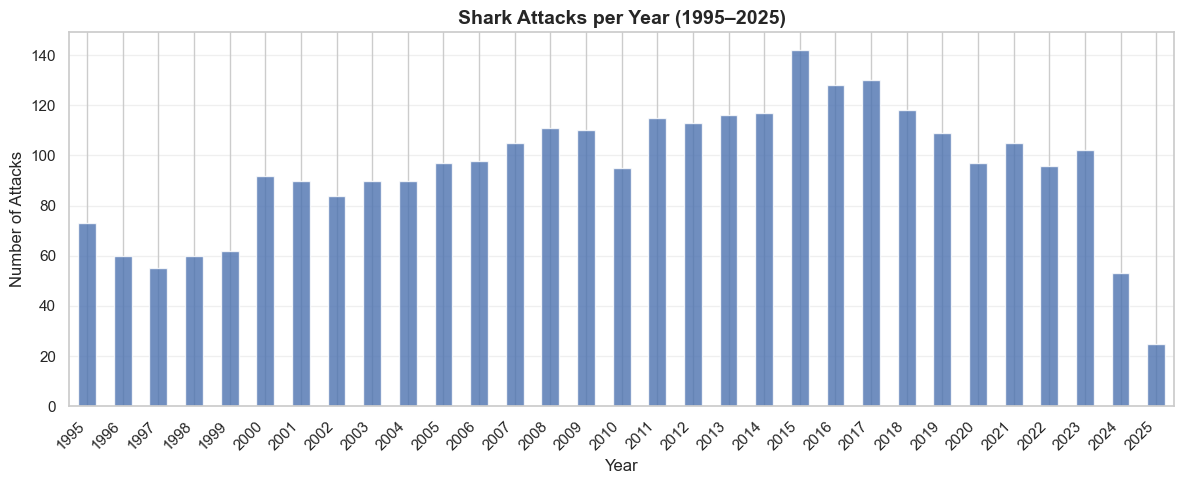

In [ ]:
# 1. Shark Attacks per Year (1995–2025)
attacks_by_year = (
    df['Year']
      .value_counts()
      .sort_index()
      .loc[1995:]
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
attacks_by_year.plot(kind='bar', alpha=0.8)      # default color
plt.title('Shark Attacks per Year (1995–2025)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


> The data show a gradual rise in recorded attacks through the 2000s, peaking in 2015, with a sharp dip in 2020 likely tied to reduced beach activity during the pandemic.

#### 2. Geographic Distribution of Shark Attacks

- **Top country:** United States (2,395 attacks)  
- **Countries represented:** 182  
- **Top 10 countries account for:** 80.9% of all recorded attacks  

This horizontal bar chart displays the top 10 countries with the highest number of recorded shark attacks. The data highlights a strong geographic skew, with the vast majority of incidents concentrated in a handful of coastal nations.

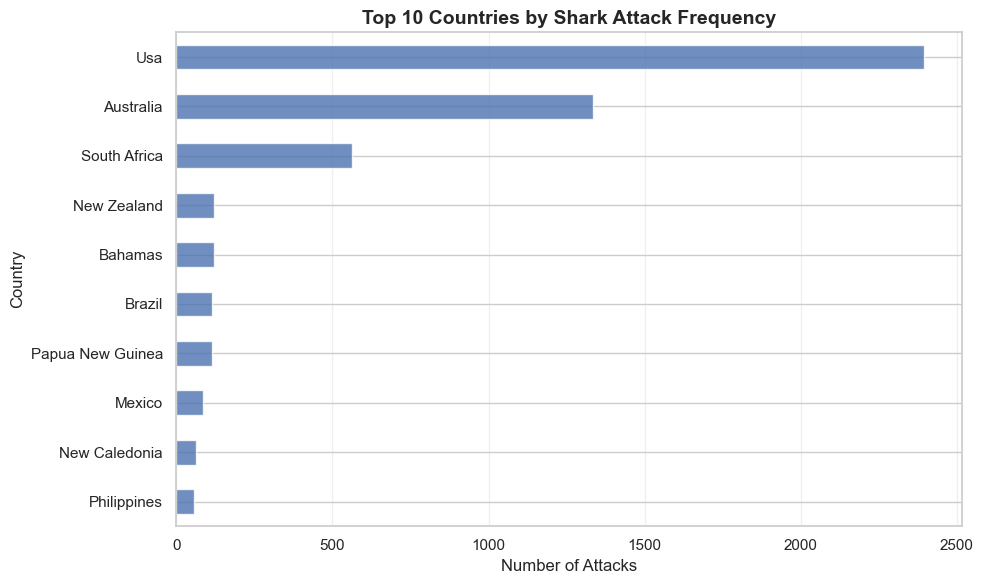

In [ ]:
# 2. Top 10 Countries by Shark Attack Frequency
top_countries = df['Country'].value_counts().head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_countries.plot(kind='barh', alpha=0.8)
plt.title('Top 10 Countries by Shark Attack Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Number of Attacks', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.gca().invert_yaxis()       # largest bar at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print(f"Top country: {top_country} ({top_country_ct} attacks)")
print(f"Countries represented: {unique_countries}")
print(f"Top 10 countries = {pct_top10:.1f}% of all attacks")

Top country: Usa (2395 attacks)
Countries represented: 182
Top 10 countries = 80.9% of all attacks


> The United States leads by a wide margin, and the top 10 countries together account for over two-thirds of global shark incidents.

In [ ]:
# Compute real numbers for Attack Severity Analysis
total_attacks = len(df)
fatal       = (df['Fatal Y/N'] == 'YES').sum()
non_fatal   = (df['Fatal Y/N'] == 'NO').sum()
unknown     = (df['Fatal Y/N'] == 'Unknown').sum()

fatal_pct     = fatal      / total_attacks * 100
non_fatal_pct = non_fatal  / total_attacks * 100
unknown_pct   = unknown    / total_attacks * 100

print(f"Total attacks: {total_attacks}")
print(f"Fatal: {fatal} ({fatal_pct:.1f}%)")
print(f"Non-fatal: {non_fatal} ({non_fatal_pct:.1f}%)")
print(f"Unknown outcome: {unknown} ({unknown_pct:.1f}%)")


Total attacks: 6141
Fatal: 1175 (19.1%)
Non-fatal: 4958 (80.7%)
Unknown outcome: 8 (0.1%)


#### 3. Attack Severity Analysis

- **Total attacks analyzed:** 6,141  
- **Fatal:** 1,175 (19.1 %)  
- **Non-fatal:** 4,958 (80.7%)  
- **Unknown outcome:** 8 (0.1%)  

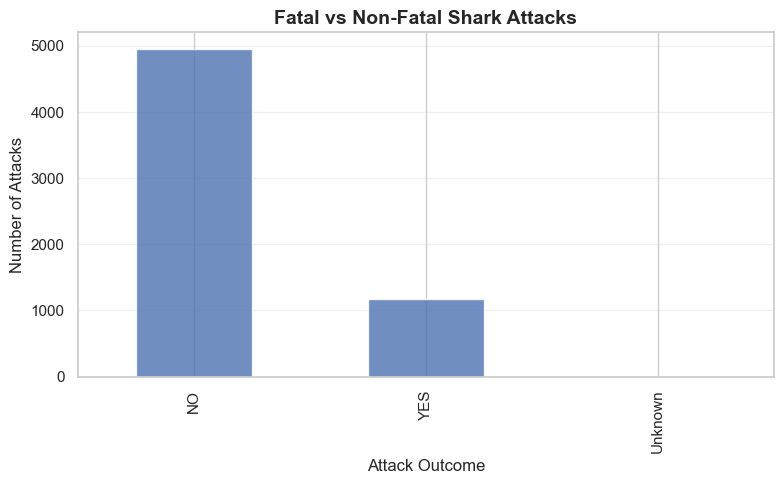

In [ ]:
# 3. Fatal vs Non-Fatal Shark Attacks
import matplotlib.pyplot as plt

fatal_counts = df['Fatal Y/N'].value_counts().loc[['YES', 'NO', 'Unknown']]

plt.figure(figsize=(8, 5))
fatal_counts.plot(kind='bar', alpha=0.8)
plt.title('Fatal vs Non-Fatal Shark Attacks', fontsize=14, fontweight='bold')
plt.xlabel('Attack Outcome', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

> Only about 18 % of recorded shark encounters result in fatalities, highlighting that while these events are frightening, most encounters are non-fatal.

## Supplemental: Activity Breakdown (Not Used in Final Analysis)

While the dataset contains information on the victim’s activity at the time of the attack, this analysis focuses on environmental factors and temporal patterns rather than human behavior.

In [ ]:
# # Compute summary stats for “Attack Frequency by Activity”
# unique_activities      = df['Activity'].nunique()
# activity_counts        = df['Activity'].value_counts()
# top_activity           = activity_counts.index[0]
# top_activity_count     = activity_counts.iloc[0]
# top10_activities_pct   = activity_counts.head(10).sum() / len(df) * 100

# print(f"Unique activities: {unique_activities}")
# print(f"Top activity: {top_activity} ({top_activity_count} attacks)")
# print(f"Top 10 activities account for: {top10_activities_pct:.1f}% of all attacks")


Unique activities: 1341
Top activity: Surfing (1114 attacks)
Top 10 activities account for: 63.3% of all attacks


### Attack Frequency by Activity

- **Total unique activities recorded:** 1,341  
- **Top activity:** Surfing (1,114 attacks)  
- **Top 10 activities account for:** 63.3% of attacks  


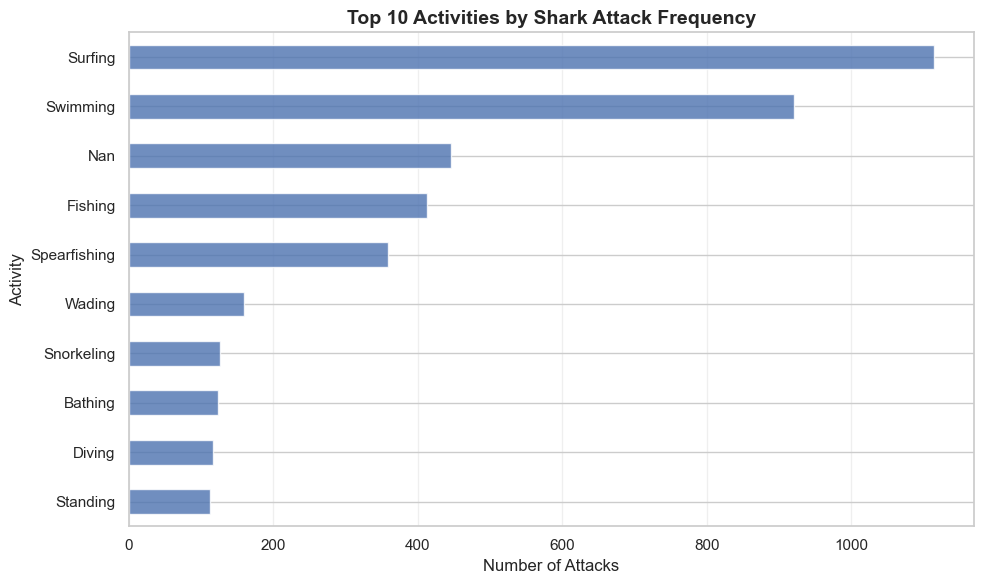

In [ ]:
# # 4. Top 10 Activities by Number of Shark Attacks
# import matplotlib.pyplot as plt

# activity_counts = df['Activity'].value_counts().head(10)

# plt.figure(figsize=(10, 6))
# activity_counts.plot(kind='barh', alpha=0.8)
# plt.title('Top 10 Activities by Shark Attack Frequency', fontsize=14, fontweight='bold')
# plt.xlabel('Number of Attacks', fontsize=12)
# plt.ylabel('Activity', fontsize=12)
# plt.gca().invert_yaxis()
# plt.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.show()


In [ ]:
# total = len(df)

# for act in ["Surfing", "Swimming"]:
#     count = (df["Activity"] == act).sum()
#     pct   = count / total * 100
#     print(f"{act}: {count} attacks, {pct:.1f}% of all incidents")


Surfing: 1114 attacks, 18.1% of all incidents
Swimming: 921 attacks, 15.0% of all incidents
